In [1]:
%%capture
!pip install ipywidgets
!pip install autogluon scikit-learn==1.5.2

In [2]:
%%capture
!apt-get install -y graphviz graphviz-dev && pip install pydot
!pip install pygraphviz

In [3]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from time import time
from tqdm.auto import tqdm
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import shap

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [4]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e10/"
submit = pd.read_csv(PATH+"sample_submission.csv")
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
orig = pd.read_csv("/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_100k.csv")

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

In [5]:
display(train.head())
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [6]:
# ## -- Option 1: USE ORIGINAL DATA AS ROWS --
# train = pd.concat([train, orig], ignore_index=True)
# train.name = 'original_as_rows'

# ## -- Option 2: USE ORIGINAL DATA AS COLUMNS --
# print(f"Merging {len(FEATURES)} features...", end="")
# for c in FEATURES:
#     tmp = orig.groupby(c)[TARGET].mean()
#     n = f"orig_{c}"
#     print(f"{n}, ", end="")
#     tmp.name = n
#     train = train.merge(tmp, on=c, how='left')
#     test  = test.merge(tmp, on=c, how='left')
#     train.name = 'original_as_columns'

# train.shape

In [7]:
# !rm -r /kaggle/working/AG_accident_models

In [8]:
from autogluon.tabular import TabularPredictor

## -- RUN 1: Use train data --
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "regression",
          eval_metric = "rmse",
                 path = "./AG_accident_models",
).fit(
                   train_data = train,
                      presets = 'best_quality',
                num_bag_folds = 10,
             dynamic_stacking = False,
             num_stack_levels = 1,
                 # num_bag_sets = 2,
                   time_limit = 3600*11,
        # [ 'XGB', 'GBM', 'CAT', 'RF', 'XT', 'FASTAI', 'NN_TORCH']
         # included_model_types = ['RF', 'XT', 'FASTAI'],
                  # ag_args_fit = {'num_cpus': os.cpu_count() - 1},
                     # num_gpus = torch.cuda.device_count(),
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.94 GB / 31.35 GB (95.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=10, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 39600s
AutoGluon will save models to "/kaggle/working/AG_accident_models"
Train Data Rows:    517754
Train Data Columns: 12
Label Column:       accident_risk
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30720.05 MB
	Train Data (Original)  Memory U

In [9]:
## -- Get Summary -- 
print(f"""
    ---> Total models : {len(predictor.model_names())}
    ---> Best model   : {predictor.model_best}
        """)

## -- Observe RUN 1 RESULTS --
leaderboard = predictor.leaderboard(silent=True)
display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))


    ---> Total models : 26
    ---> Best model   : WeightedEnsemble_L3
        


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.055878,root_mean_squared_error,612.142807,36833.252097,0.007993,2.783771,3,True,26
1,ExtraTreesMSE_BAG_L2,-0.055934,root_mean_squared_error,553.667084,26645.868757,25.866874,405.405063,2,True,18
2,LightGBM_BAG_L2,-0.055946,root_mean_squared_error,539.995079,26363.069301,12.194869,122.605607,2,True,15
3,WeightedEnsemble_L2,-0.055960,root_mean_squared_error,58.054524,17679.883665,0.007939,1.317396,2,True,13
4,NeuralNetFastAI_BAG_L2,-0.055960,root_mean_squared_error,538.512923,28155.412138,10.712713,1914.948444,2,True,19
5,XGBoost_BAG_L2,-0.055963,root_mean_squared_error,535.706251,26336.042171,7.906040,95.578477,2,True,20
6,LightGBMLarge_BAG_L2,-0.055966,root_mean_squared_error,546.114594,26398.604054,18.314383,158.140360,2,True,22
7,CatBoost_BAG_L2,-0.055970,root_mean_squared_error,529.925923,31318.001204,2.125713,5077.537510,2,True,17
8,CatBoost_r177_BAG_L2,-0.055972,root_mean_squared_error,529.071543,26855.454738,1.271333,614.991044,2,True,23
9,LightGBMLarge_BAG_L1,-0.055991,root_mean_squared_error,27.661220,146.994363,27.661220,146.994363,1,True,9


In [10]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [11]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [12]:
## -- Create folder directory to save predictions --
NAME_EXT = "_BASE-CPU"
FOLDER   = "AG_accident_predictions"
!mkdir /kaggle/working/{FOLDER}{NAME_EXT}
# PREDS_PATH = "/kaggle/working/AG_accident_predictions"

In [13]:
## -- Make predictions from best model --
pred_df = predictor.predict(test)
pred_df.head()

id
517754    0.300967
517755    0.122836
517756    0.185183
517757    0.314262
517758    0.403152
Name: accident_risk, dtype: float32

In [14]:
## -- Generate Submission --
SUBMIT_FILE = f'submit_AG{NAME_EXT}.csv'

submit = pd.read_csv(PATH+"sample_submission.csv")
submit[TARGET] = pred_df.values
submit.to_csv(SUBMIT_FILE, index=False)
print(f"---> Submission file saved as: {SUBMIT_FILE} !")
submit.head(10)

---> Submission file saved as: submit_AG_BASE-CPU.csv !


,id,accident_risk
0,517754,0.300967
1,517755,0.122836
2,517756,0.185183
3,517757,0.314262
4,517758,0.403152
5,517759,0.460035
6,517760,0.263782
7,517761,0.198255
8,517762,0.375946
9,517763,0.320920


In [15]:
## -- Generate prediction probabilities for all models --
ag_multi_test_proba = predictor.predict_multi(test)

## -- Get TEST PREDICTIONS of all models --
final_test_data = {}

for k, v in tqdm(ag_multi_test_proba.items(), desc="Exporting TEST predictions"):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_test_data[k_renamed] = v

SAVE_PRED = f"/kaggle/working/{FOLDER}{NAME_EXT}/pred_ag{NAME_EXT}.parquet"
final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(SAVE_PRED, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/26 [00:00<?, ?it/s]

,LightGBMXTBAGL1_BASE-CPU,LightGBMBAGL1_BASE-CPU,RandomForestMSEBAGL1_BASE-CPU,CatBoostBAGL1_BASE-CPU,ExtraTreesMSEBAGL1_BASE-CPU,NeuralNetFastAIBAGL1_BASE-CPU,XGBoostBAGL1_BASE-CPU,NeuralNetTorchBAGL1_BASE-CPU,LightGBMLargeBAGL1_BASE-CPU,CatBoostr177BAGL1_BASE-CPU,NeuralNetTorchr79BAGL1_BASE-CPU,LightGBMr131BAGL1_BASE-CPU,WeightedEnsembleL2_BASE-CPU,LightGBMXTBAGL2_BASE-CPU,LightGBMBAGL2_BASE-CPU,RandomForestMSEBAGL2_BASE-CPU,CatBoostBAGL2_BASE-CPU,ExtraTreesMSEBAGL2_BASE-CPU,NeuralNetFastAIBAGL2_BASE-CPU,XGBoostBAGL2_BASE-CPU,NeuralNetTorchBAGL2_BASE-CPU,LightGBMLargeBAGL2_BASE-CPU,CatBoostr177BAGL2_BASE-CPU,NeuralNetTorchr79BAGL2_BASE-CPU,LightGBMr131BAGL2_BASE-CPU,WeightedEnsembleL3_BASE-CPU
id,,,,,,,,,,,,,,,,,,,,,,,,,,
517754,0.294755,0.290229,0.313911,0.291364,0.311311,0.301957,0.292879,0.299470,0.292649,0.292535,0.296692,0.290283,0.294262,0.299263,0.298295,0.308177,0.298872,0.303267,0.293625,0.297368,0.307166,0.297747,0.299470,0.296612,0.302645,0.300967
517755,0.122098,0.123227,0.119186,0.120213,0.120867,0.117350,0.121444,0.123734,0.123210,0.120329,0.121239,0.125164,0.121608,0.121372,0.123223,0.122554,0.122555,0.123469,0.121644,0.121800,0.127550,0.123355,0.122757,0.118759,0.150372,0.122836
517756,0.187414,0.184990,0.174061,0.186958,0.176572,0.193113,0.186534,0.186919,0.184392,0.185673,0.184767,0.186768,0.184386,0.183032,0.184352,0.190723,0.183485,0.184373,0.183557,0.182260,0.193211,0.184005,0.183950,0.179166,0.204294,0.185183
517757,0.317021,0.314718,0.315769,0.310624,0.319574,0.319712,0.315511,0.315561,0.319525,0.312818,0.320779,0.316562,0.315589,0.314170,0.314582,0.310208,0.313572,0.315758,0.315632,0.315252,0.317835,0.315311,0.313691,0.312966,0.319585,0.314262
517758,0.393135,0.407907,0.409654,0.395902,0.408156,0.400211,0.405033,0.400308,0.408619,0.396374,0.395035,0.405391,0.403636,0.400999,0.400293,0.403727,0.402952,0.404486,0.404821,0.400870,0.397229,0.402502,0.399244,0.399526,0.394527,0.403152


In [16]:
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
for model in tqdm(predictor.model_names(), desc="Processing OOF probabilities"):
    ag_multi_oof_preds[model] = predictor.predict_oof(
                                         model = model,
                                    train_data = train
                                )

final_oof_data = {}
for k, v in tqdm(ag_multi_oof_preds.items(), desc="Exporting OOF predictions"):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_oof_data[k_renamed] = v
    
SAVE_OOF = f"/kaggle/working/{FOLDER}{NAME_EXT}/oof_ag{NAME_EXT}.parquet"
final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(SAVE_OOF, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/26 [00:00<?, ?it/s]

,LightGBMXTBAGL1_BASE-CPU,LightGBMBAGL1_BASE-CPU,RandomForestMSEBAGL1_BASE-CPU,CatBoostBAGL1_BASE-CPU,ExtraTreesMSEBAGL1_BASE-CPU,NeuralNetFastAIBAGL1_BASE-CPU,XGBoostBAGL1_BASE-CPU,NeuralNetTorchBAGL1_BASE-CPU,LightGBMLargeBAGL1_BASE-CPU,CatBoostr177BAGL1_BASE-CPU,NeuralNetTorchr79BAGL1_BASE-CPU,LightGBMr131BAGL1_BASE-CPU,WeightedEnsembleL2_BASE-CPU,LightGBMXTBAGL2_BASE-CPU,LightGBMBAGL2_BASE-CPU,RandomForestMSEBAGL2_BASE-CPU,CatBoostBAGL2_BASE-CPU,ExtraTreesMSEBAGL2_BASE-CPU,NeuralNetFastAIBAGL2_BASE-CPU,XGBoostBAGL2_BASE-CPU,NeuralNetTorchBAGL2_BASE-CPU,LightGBMLargeBAGL2_BASE-CPU,CatBoostr177BAGL2_BASE-CPU,NeuralNetTorchr79BAGL2_BASE-CPU,LightGBMr131BAGL2_BASE-CPU,WeightedEnsembleL3_BASE-CPU
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.123798,0.130988,0.128190,0.127066,0.128116,0.128104,0.129695,0.128737,0.129181,0.127751,0.126302,0.130328,0.128236,0.127235,0.131578,0.128031,0.129961,0.129261,0.127773,0.129952,0.133531,0.130357,0.126180,0.125966,0.160276,0.128996
1,0.326822,0.322766,0.322773,0.323791,0.322393,0.322712,0.325438,0.323863,0.324336,0.328806,0.327792,0.320428,0.323961,0.327670,0.324352,0.324912,0.319423,0.322650,0.325940,0.323537,0.332659,0.318698,0.322204,0.331932,0.324519,0.323553
2,0.387574,0.390099,0.383717,0.389361,0.388670,0.396147,0.390066,0.394491,0.387065,0.387690,0.387144,0.387193,0.387648,0.389647,0.389509,0.391893,0.389483,0.389683,0.388189,0.387898,0.384942,0.389468,0.384922,0.372410,0.384916,0.389360
3,0.123160,0.131264,0.131694,0.129831,0.129935,0.129962,0.129895,0.137254,0.130357,0.129508,0.132965,0.131698,0.130281,0.130132,0.129662,0.133392,0.132033,0.130469,0.131944,0.129638,0.135152,0.130089,0.131538,0.134326,0.161004,0.131287
4,0.474143,0.471626,0.468467,0.470779,0.471436,0.469957,0.471685,0.464010,0.469063,0.470431,0.471247,0.471509,0.469690,0.468683,0.469575,0.473513,0.469152,0.466659,0.469040,0.469247,0.465553,0.468992,0.468089,0.461701,0.453359,0.469011


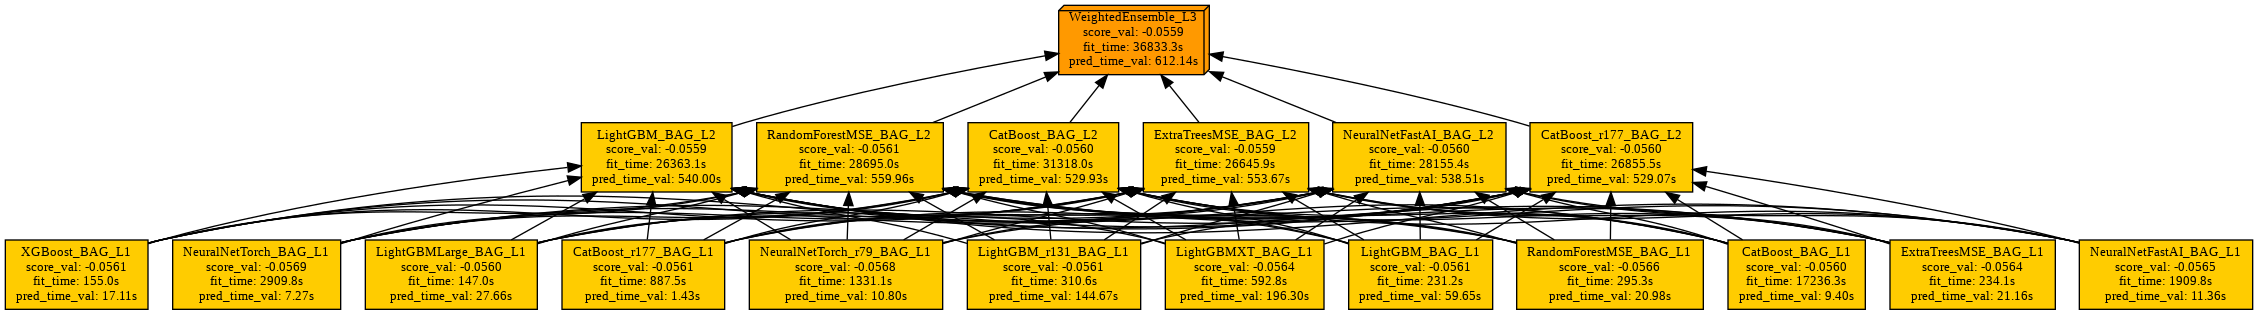

In [17]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_accident_models/ensemble_model.png'))

In [18]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
!zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

  adding: kaggle/working/AG_accident_predictions_BASE-CPU/ (stored 0%)
  adding: kaggle/working/AG_accident_predictions_BASE-CPU/oof_ag_BASE-CPU.parquet (deflated 10%)
  adding: kaggle/working/AG_accident_predictions_BASE-CPU/pred_ag_BASE-CPU.parquet (deflated 9%)


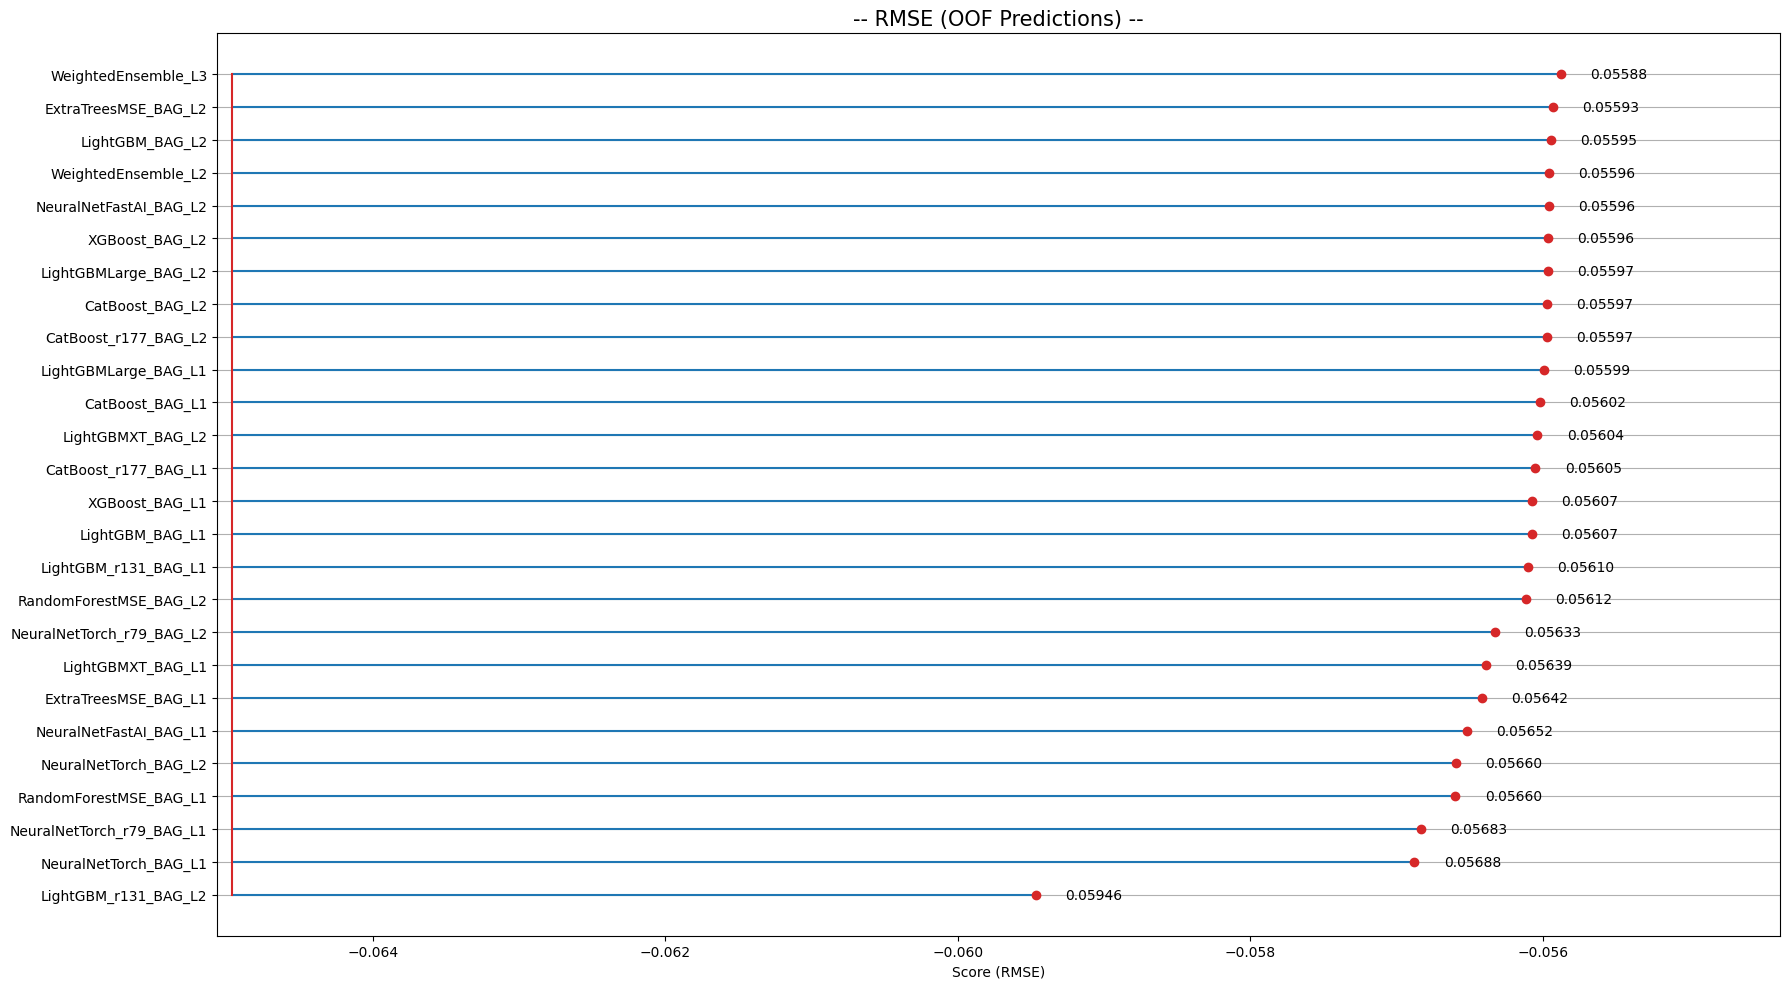

In [19]:
## -- EXTRACT MODEL AND SCORES --
result_dict = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_dict, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 10))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.0056, max_score + 0.0015)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE (OOF Predictions) --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+2e-4, i, f'{abs(value):.5f}', ha='left', va='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [20]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_accident_models
!rm -r /kaggle/working/{FOLDER}{NAME_EXT}

In [21]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

